# Creating datasets and dataloaders

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset

In [2]:
class GPTdatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        
        tokenIDs = tokenizer.encode(txt)
        
        for i in range(0, len(tokenIDs) - max_length, stride):
            self.input_ids.append(torch.tensor(tokenIDs[i:i+max_length]))
            self.target_ids.append(torch.tensor(tokenIDs[i+1:i+max_length+1]))
            
    def __len__(self):
        return(len(self.input_ids))
    
    def __getitem__(self, index):
        input = self.input_ids[index]
        label = self.target_ids[index]
        return input, label

In [3]:
def creat_dataloader_V1(txt, tokenizer, batch_size, max_length=256, stride=128,
                        shuffle=True, drop_last=True, num_workers=0):
    dataset = GPTdatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                            drop_last=drop_last, num_workers=num_workers)
    return dataloader

# Multi-Head Attention mechanism

In [4]:
import torch.nn as nn

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_size, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert(d_out%num_heads==0), "d_out must be a multiple of num_heads"
        self.head_dim = d_out//num_heads
        self.num_heads = num_heads
        self.d_out = d_out
        self.Q_layer = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.K_layer = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.V_layer = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_size, context_size), diagonal=1))
    
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        Q = self.Q_layer(x)
        K = self.K_layer(x)
        V = self.V_layer(x)

        Q = Q.view(b, num_tokens, self.num_heads, self.head_dim)
        K = K.view(b, num_tokens, self.num_heads, self.head_dim)
        V = V.view(b, num_tokens, self.num_heads, self.head_dim)
        
        Q.transpose_(1, 2)
        K.transpose_(1, 2)
        V.transpose_(1, 2)
        
        attention_scores = Q@K.transpose(-1, -2)
        
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        attention_scores.masked_fill_(mask_bool, -torch.inf)
        
        attention_weights = torch.softmax(attention_scores/self.head_dim**0.5, dim=-1)
        attention_weights = self.dropout(attention_weights)

        context_vec = (attention_weights@V).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        
        context_vec = self.out_proj(context_vec)
        
        return context_vec
        

# GPT architecture

**Configuration for the model**

In [6]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

**Layer Normalization Class**

In [7]:
class layer_norm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True)
        norm_out = (x - mean)/(torch.sqrt(var) + self.eps)
        return self.scale*norm_out + self.shift

**GELU activation class**

In [8]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        out = 0.5*x*(1 + torch.tanh(torch.sqrt(torch.tensor(2/torch.pi))*(x + 0.044715*x**3)))
        return out

**Feed-Forward class**

In [9]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
            )
    def forward(self, x):
        return self.layers(x)

**Transformer block**

In [10]:
class Transformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layer_norm1 = layer_norm(cfg['emb_dim'])
        self.Masked_multi_head_attn = MultiHeadAttention(
            cfg['emb_dim'], cfg['emb_dim'],
            cfg['context_length'], cfg['drop_rate'], cfg['n_heads'], cfg['qkv_bias'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
        self.layer_norm2 = layer_norm(cfg['emb_dim'])
        self.ff = FeedForward(cfg)
           
    def forward(self, x):
        
        shortcut = x
        
        x = self.layer_norm1(x)
        x = self.Masked_multi_head_attn(x)
        x = self.dropout(x) + shortcut
        
        shortcut = x
        
        x = self.layer_norm2(x)
        x = self.ff(x)
        x = self.dropout(x) + shortcut
        
        return x
         
        

**Model**

In [11]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
        self.transformer_layer = nn.Sequential(*[Transformer(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm_layer = layer_norm(cfg['emb_dim'])
        self.linear_out_layer = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        token_emb = self.tok_emb(in_idx)
        positional_emb = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        embeddings = token_emb + positional_emb
        
        embeddings = self.dropout(embeddings)
        
        x = self.transformer_layer(embeddings)
        
        x = self.final_norm_layer(x)
        
        logits = self.linear_out_layer(x)
        
        return logits

# Simple output tokenID generation function

**Text to tokens generation function**

In [12]:
# Input : text and tokenizer
# Output : tokens in a single batch (1, num_tokens)
def text_to_tokens(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    tokens = torch.tensor(encoded).unsqueeze(0)  # .unsqueeze() converts (n, ) --> (1, n)
    return tokens

**Input tokens to output tokens generation function**

In [13]:
# input : idx is the input tokens in batch (num_batches, num_tokens)
# output : return num_tokens output tokens concatenated with input tokens
# Remember that this returns the output in shape (num_batches, num_tokens) 
# to convert these tokens into texts we need to arrange all tokens in a
# single python list then pass it to the tokenizer.decode() to decode
def generated_tokens_simple(model, idx, num_tokens, context_size):
    for _ in range(num_tokens):
        input = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(input)
        logits = logits[:, -1, :]
        prob_dist = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(prob_dist, dim=-1, keepdim=True)
        idx = torch.cat([idx, idx_next], dim=-1)
    return idx

**Tokens to text generation functon**

In [14]:
# Input : tokens (1, num_tokens)
# Output : text
def tokens_to_text(tokens, tokenizer):
    tokens = tokens.squeeze(0).tolist()  # .squeeze() converts (1, n) --> (n, )
    text = tokenizer.decode(tokens)
    return text

# Model Pre-training

**Cross Entropy Loss calculation funtion**

In [15]:
# Loss calculation for one batch
def cal_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    logits = logits.flatten(0, 1)
    targets = target_batch.flatten()
    loss = nn.functional.cross_entropy(logits, targets)
    return loss

In [16]:
# Loss calculation for whole dataloader
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader)==0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss = cal_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

**Model evaluation function to return Training and Validation losses**

In [17]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

**The below function is used for visual evaluation process <br> as it prints sample text outputs during model training**

In [18]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_tokens(start_context, tokenizer).to(device)
    with torch.no_grad():
        out_tokens = generated_tokens_simple(model=model, idx=encoded,
                                          num_tokens=50, context_size=context_size)
    decoded_text = tokens_to_text(out_tokens, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()
        

**Model training function**

In [19]:
def train_model_simple(model, train_loader, val_loader, optimizer, device,
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = cal_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            
            if global_step%eval_freq==0:
                train_loss, val_loss = evaluate_model(model, train_loader,
                                                       val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}):"
                      f"Training loss: {train_loss:.3f},"
                      f"Validation loss: {val_loss:.3f}")
                
        generate_and_print_sample(model, tokenizer, device, start_context)
        
    return train_losses, val_losses, track_tokens_seen

**Starting to train the model**

**Changing the configuration slightly just by making the context_length=256 from 1024 original**

In [20]:
GPT_CONFIG_124M = {
    'vocab_size': 50257,
    'context_length': 256,
    'emb_dim': 768,
    'n_heads': 12,
    'n_layers': 12,
    'drop_rate': 0.1,
    'qkv_bias': False
    }

**Importing "The-Verdict" a short story as dataset for training**

In [21]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    text_data = f.read()

**Splitting dataset into training and validation data**

In [22]:
splitting_frac = 0.9
split_idx = int(splitting_frac*len(text_data))
train_text = text_data[:split_idx]
val_text = text_data[split_idx:]

**Creating training and validation dataloaders**

In [23]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

In [24]:
torch.manual_seed(123)
train_loader = creat_dataloader_V1(train_text,
                                    tokenizer,
                                    batch_size=2,
                                    max_length=GPT_CONFIG_124M['context_length'],
                                    stride=GPT_CONFIG_124M['context_length'],
                                    shuffle=True,
                                    drop_last=True,
                                    num_workers=0
                                    )
val_loader = creat_dataloader_V1(val_text,
                                tokenizer,
                                batch_size=2,
                                max_length=GPT_CONFIG_124M['context_length'],
                                stride=GPT_CONFIG_124M['context_length'],
                                shuffle=False,
                                drop_last=False,
                                num_workers=0
                                )

In [25]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
start_context = "Every step moves you"
train_losses, val_losses, track_tokens_seen = train_model_simple(model, train_loader,
                                                                 val_loader,
                                                                 optimizer, device,
                                                                    num_epochs, eval_freq=5,
                                                                    eval_iter=5,
                                                                    start_context=start_context,
                                                                    tokenizer=tokenizer)


Ep 1 (Step 000000):Training loss: 9.782,Validation loss: 9.934
Ep 1 (Step 000005):Training loss: 8.112,Validation loss: 8.340
Every step moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010):Training loss: 6.662,Validation loss: 7.049
Ep 2 (Step 000015):Training loss: 5.961,Validation loss: 6.616
Every step moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020):Training loss: 5.716,Validation loss: 6.594
Ep 3 (Step 000025):Training loss: 5.210,Validation loss: 6.355
Every step moves you, and I had been.                                            
Ep 4 (Step 000030):Training loss: 4.427,Validation loss: 6.279
Ep 4 (Step 000035):Training loss: 4.075,Validation loss: 6.227
Every step moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040):Training loss: 3.737,Validation loss: 6.160
E

**Plotting Training and validation losses over number of epochs**

In [26]:
import matplotlib.pyplot as plt

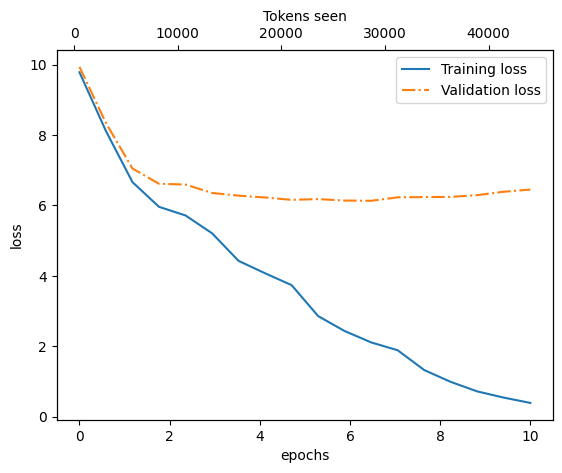

In [27]:
epoch_tensor = torch.linspace(0, num_epochs, len(train_losses))
fig, ax1 = plt.subplots()
ax1.plot(epoch_tensor, train_losses, label="Training loss")
ax1.plot(epoch_tensor, val_losses, linestyle="-.", label="Validation loss")
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.legend()
ax2 = ax1.twiny()
ax2.plot(track_tokens_seen, train_losses, alpha=0)
ax2.set_xlabel("Tokens seen")
plt.show()

# Temperature scaling and Top-k sampling

In [28]:
def generated_tokens_simple_V2(model, idx, max_new_tokens, context_size,
                               temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        input = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(input)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, top_pos = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits<min_val,
                                 torch.tensor(float('-inf')).to(logits.device),
                                 logits)
        if temperature > 0.0:
            logits = logits/temperature
            prob_dist = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(prob_dist, num_samples=1)
        else:
            prob_dist = torch.softmax(logits, dim=-1)
            idx_next = torch.argmax(prob_dist, dim=-1, keepdim=True)
        if idx_next==eos_id:
            break
        idx = torch.cat([idx, idx_next], dim=-1)
    return idx

In [29]:
def generate(model, input_context, max_new_tokens, context_size,
                               temperature=0.0, top_k=None, eos_id=None):
    model.eval()
    input_tkns = text_to_tokens(input_context, tokenizer)
    output_tkns = generated_tokens_simple_V2(model, input_tkns, max_new_tokens, context_size,
                               temperature, top_k, eos_id)
    output_txt = tokens_to_text(output_tkns, tokenizer)
    print(output_txt)

In [30]:
input_txt = "Every step moves you"
generate(model=model, input_context=input_txt, max_new_tokens=50, context_size=15, temperature=0.5, top_k=5)

Every step moves you know," was one of the axioms he laid down, so--so of the fact--so of the irony.





"Oh, and told me out--so a deprecating a deprecatingly--


# Saving and loading model weights and Optimizer states

In [31]:
torch.save({
    'model_state_dict' : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict()
            },
    'model_and_optimizer.pth'
    )

In [32]:
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train();

# Loading pretrained weights from OpenAI

In [33]:
# gpt_download.py is a python file which contains functions to download open source weights from OpenAI

from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


**As same architecture can be used for all GPT2 models we define the config. for all models**

In [34]:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25}
}

In [35]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

**Earlier we set the context_length to 256 from 1024 for the sake of training the model<br>Also OpenAI used bias vectors in the Multihead attention so we are turning qkv_bias to true**

In [36]:
NEW_CONFIG.update({'context_length': 1024, 'qkv_bias': True})
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': True}

In [37]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

**We will first define a small "assign" utility function that checks whether two tensors or arrays (left and right) have the same dimensions or shape and returns the right tensor as trainable PyTorch parameters:**

In [38]:
def assign(left, right):
    if left.shape!=right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                         f"Right: {right.shape}"
                         )
    return torch.nn.Parameter(torch.tensor(right, device=left.device))

### Replacing our weights and biases with OpenAI's weights and biases

In [39]:
import numpy as np

def load_params_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"]["w"]), 3, axis=-1)
        gpt.transformer_layer[b].Masked_multi_head_attn.Q_layer.weight = assign(
            gpt.transformer_layer[b].Masked_multi_head_attn.Q_layer.weight, q_w.T)
        gpt.transformer_layer[b].Masked_multi_head_attn.K_layer.weight = assign(
            gpt.transformer_layer[b].Masked_multi_head_attn.K_layer.weight, k_w.T)
        gpt.transformer_layer[b].Masked_multi_head_attn.V_layer.weight = assign(
            gpt.transformer_layer[b].Masked_multi_head_attn.V_layer.weight, v_w.T)
        
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"]["b"]), 3, axis=-1)
        gpt.transformer_layer[b].Masked_multi_head_attn.Q_layer.bias = assign(
            gpt.transformer_layer[b].Masked_multi_head_attn.Q_layer.bias, q_b)
        gpt.transformer_layer[b].Masked_multi_head_attn.K_layer.bias = assign(
            gpt.transformer_layer[b].Masked_multi_head_attn.K_layer.bias, k_b)
        gpt.transformer_layer[b].Masked_multi_head_attn.V_layer.bias = assign(
            gpt.transformer_layer[b].Masked_multi_head_attn.V_layer.bias, v_b)
        
        gpt.transformer_layer[b].Masked_multi_head_attn.out_proj.weight = assign(
            gpt.transformer_layer[b].Masked_multi_head_attn.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_layer[b].Masked_multi_head_attn.out_proj.bias = assign(
            gpt.transformer_layer[b].Masked_multi_head_attn.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])
        
        gpt.transformer_layer[b].ff.layers[0].weight = assign(
            gpt.transformer_layer[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_layer[b].ff.layers[0].bias = assign(
            gpt.transformer_layer[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_layer[b].ff.layers[2].weight = assign(
            gpt.transformer_layer[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_layer[b].ff.layers[2].bias = assign(
            gpt.transformer_layer[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        
        gpt.transformer_layer[b].layer_norm1.scale = assign(
            gpt.transformer_layer[b].layer_norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_layer[b].layer_norm1.shift = assign(
            gpt.transformer_layer[b].layer_norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_layer[b].layer_norm2.scale = assign(
            gpt.transformer_layer[b].layer_norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_layer[b].layer_norm2.shift = assign(
            gpt.transformer_layer[b].layer_norm2.shift,
            params["blocks"][b]["ln_2"]["b"])
        
    gpt.final_norm_layer.scale = assign(gpt.final_norm_layer.scale, params["g"])
    gpt.final_norm_layer.shift = assign(gpt.final_norm_layer.shift, params["b"])
    gpt.linear_out_layer.weight = assign(gpt.linear_out_layer.weight, params["wte"])
      

In [40]:
load_params_into_gpt(gpt, params)
gpt.to(device);

### Giving some input to the model and if model produces some coherent text then everything is good

In [41]:
torch.manual_seed(353)
input_context = "Education is the key to"
output = generate(model=gpt, input_context=input_context,
                  max_new_tokens=25, context_size=1024,
                  temperature=1.5, top_k=50)
print(output)

Education is the key to building the future of the next generation—our kids and this world," Doreen Doss told the Washington Examiner recently!
None
